<a href="https://colab.research.google.com/github/hrishi508/Self-and-Semi-Supervised-Learning/blob/main/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [5]:
import matplotlib.pyplot as plt
import numpy as np


## Getting Data from ```torchvision```

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15)
])

training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=True
)

test_data = datasets.STL10(
    root="data",
    split='test',
    transform=transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def imshow(img):
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

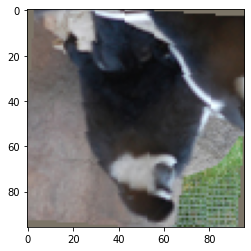

In [8]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
imshow(img)
print(labels_map[label])
print(img.shape)

In [9]:
## HYPERPARAMETERS
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 100



monkey
torch.Size([3, 96, 96])


## Preparing the dataset using ```DataLoader```

In [10]:
from torch.utils.data import DataLoader

In [11]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

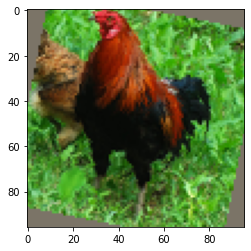

bird


In [12]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0]
imshow(img)
print(labels_map[train_labels[0].item()])

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
import time
import copy

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS):
    since = time.time()
    model = model.to(device)
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                    
                    outputs = model(inputs)
                    outputs = outputs.to(device)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = test_dataloader

In [18]:
from torchvision import models

In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [20]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv_layer = nn.Sequential(

#             # Conv Layer block 1
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Conv Layer block 2
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=0),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout2d(p=0.06),

#             # Conv Layer block 3
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=0),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )


#         self.fc_layer = nn.Sequential(
#             nn.Dropout(p=0.15),
#             nn.Linear(6400, 1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.15),
#             nn.Linear(512, 10),
#         )


#     def forward(self, x):        
#         # conv layers
#         x = self.conv_layer(x)
        
#         # flatten
#         x = x.view(x.size(0), -1)
        
#         # fc layer
#         x = self.fc_layer(x)

#         return x
       
model_ft = ResNet9(3, 10)
print(model_ft)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_ft.parameters(), lr=LR)

In [22]:
train_model(model_ft, dataloaders, loss_fn, optimizer)

Epoch 0/99
----------
train Loss: 2.0659 Acc: 0.2930
val Loss: 1.6522 Acc: 0.3925

Epoch 1/99
----------
train Loss: 1.7347 Acc: 0.3564
val Loss: 1.9217 Acc: 0.3384

Epoch 2/99
----------
train Loss: 1.5737 Acc: 0.4256
val Loss: 1.5449 Acc: 0.4330

Epoch 3/99
----------
train Loss: 1.4200 Acc: 0.4728
val Loss: 1.4033 Acc: 0.4744

Epoch 4/99
----------
train Loss: 1.3149 Acc: 0.5086
val Loss: 1.3601 Acc: 0.5016

Epoch 5/99
----------
train Loss: 1.2712 Acc: 0.5394
val Loss: 1.3663 Acc: 0.5024

Epoch 6/99
----------
train Loss: 1.2123 Acc: 0.5566
val Loss: 1.4033 Acc: 0.5079

Epoch 7/99
----------
train Loss: 1.1505 Acc: 0.5752
val Loss: 1.3920 Acc: 0.5242

Epoch 8/99
----------
train Loss: 1.0839 Acc: 0.6042
val Loss: 1.4143 Acc: 0.5058

Epoch 9/99
----------
train Loss: 1.0232 Acc: 0.6250
val Loss: 1.1762 Acc: 0.5820

Epoch 10/99
----------
train Loss: 1.0127 Acc: 0.6280
val Loss: 1.5946 Acc: 0.4725

Epoch 11/99
----------
train Loss: 0.9952 Acc: 0.6364
val Loss: 1.6431 Acc: 0.4785

Ep

(ResNet9(
   (conv1): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (conv2): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (res1): Sequential(
     (0): Sequential(
       (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
     )
     (1): Sequential(
       (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): B

In [24]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/weights_stl10.pth')

## Train Accuracy : 84%
## Validation Accuracy : 64%

In [26]:
corrects = 0
total = 0

for X,y in test_dataloader:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_ft(X)
    _, predicted = torch.max(y_pred.data, 1)
    total += y.size(0)
    corrects += (predicted == y).sum().item()

print(f"Accuracy of the model : {(float(corrects)/total)*100}%")

Accuracy of the model : 76.875%
